In [466]:
%pylab inline
import numpy as np
import seaborn as sns
from time import time


class SandHeap:
    '''Control class for managaing sandpile topples'''
    patterns = {
            '+': {
                'maxval': 4,
                'topple_cells': [(-1, 0), (1, 0), (0, -1), (0, 1)]
                },
            'x': {
                'maxval': 4,
                'topple_cells': [(-1, 1), (-1, -1), (-1, 1), (-1, -1)]
                },
            'o': {
                'maxval': 8,
                'topple_cells': [
                    (-1, 0), (1, 0), (0, -1), (0, 1),
                    (-1, 1), (-1, -1), (1, 1), (1, -1)
                    ]
                },
            'o+': {
                'maxval': 12,
                'topple_cells': [
                    (-1, 0), (1, 0), (0, -1), (0, 1),
                    (-1, 1), (-1, -1), (1, 1), (1, -1),
                    (-1, 0), (1, 0), (0, -1), (0, 1)
                    ]
                },
            'ox': {
                'maxval': 12,
                'topple_cells': [
                    (-1, 0), (1, 0), (0, -1), (0, 1),
                    (-1, 1), (-1, -1), (1, 1), (1, -1),
                    (-1, 1), (-1, -1), (-1, 1), (-1, -1)
                    ]
                }
        }

    def __init__(self, sand_power=10, topple_pattern='+'):
        self.starting_sand = 2**sand_power

        if topple_pattern in self.patterns:
            self.topple_pattern = topple_pattern
            self.max_per_cell = self.patterns[topple_pattern]['maxval']
            self.topple_cells = self.patterns[topple_pattern]['topple_cells']
        else:
            err = 'Must use one of the following topple patterns: {}'
            raise ValueError(err.format(', '.join(self.max_heap_size.keys())))

        self.init_grid()

    def init_grid(self):
        side_length = int(self.starting_sand ** 0.5)
        if self.topple_pattern == 'ox':
            side_length *= 2
        # We want an odd side length so that there is a definite centre
        if side_length % 2 == 0:
            side_length += 1
        centre = int(side_length / 2)

        grid = [[0 for j in range(side_length)] for k in range(side_length)]
        grid[centre][centre] = self.starting_sand
        self.grid = np.array([np.array(g, np.int64) for g in grid], np.int64)
        print("Grid initialised:\nside-length {}\ninitial sand {}".format(side_length, self.starting_sand))

    def topple(self, verbose=False):
        '''Topple the sand in the grid until we reach a steady state'''
        start = time()
        passes = 0

        while np.max(self.grid) >= self.max_per_cell:
            for rowix, row in enumerate(self.grid):
                if np.max(row) >= self.max_per_cell:
                    for cellix, cell in enumerate(row):
                        if cell >= self.max_per_cell:
                            self.topple_cell(rowix, cellix)
            passes += 1
            if passes % 30 == 0:
                print(".", end="")

        if verbose:
            t = time() - start
            print("\n{} passes required".format(passes))
            print("{}s to reach stable state".format(t))
        self.trim_grid()

    def topple_cell(self, row, col):
        '''Distribute sand to neighbouring cells'''
        n, rem = divmod(self.grid[row][col], self.max_per_cell)
        self.grid[row][col] = rem
        for trow, tcol in self.topple_cells:
            self.grid[row + trow][col + tcol] += n

    def trim_grid(self):
        # Trim empty
        self.grid = [r for r in self.grid if sum(r) > 0]
        # Trim empty columns
        w1 = len(self.grid[0])
        trans = [[r[n] for r in self.grid] for n in range(w1)]
        trans = [r for r in trans if sum(r) > 0]
        w2 = len(trans[0])
        self.grid = [[r[n] for r in trans] for n in range(w2)]

    def print_grid(self):
        print(s.starting_sand)
        for row in self.grid:
            line = [str(cell) for cell in row]
            print(''.join(line))

Populating the interactive namespace from numpy and matplotlib


Grid initialised:
side-length 33
initial sand 1024
...
108 passes required
0.11244964599609375s to reach stable state


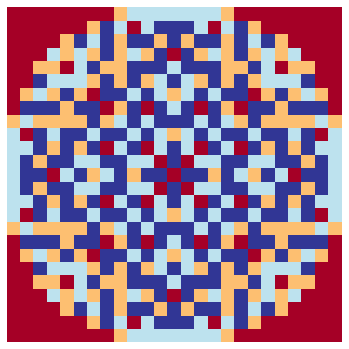

In [475]:
s = SandHeap(10, '+')
s.topple(True)
plt.figure(figsize=(6, 6))
sns.heatmap(s.grid, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")

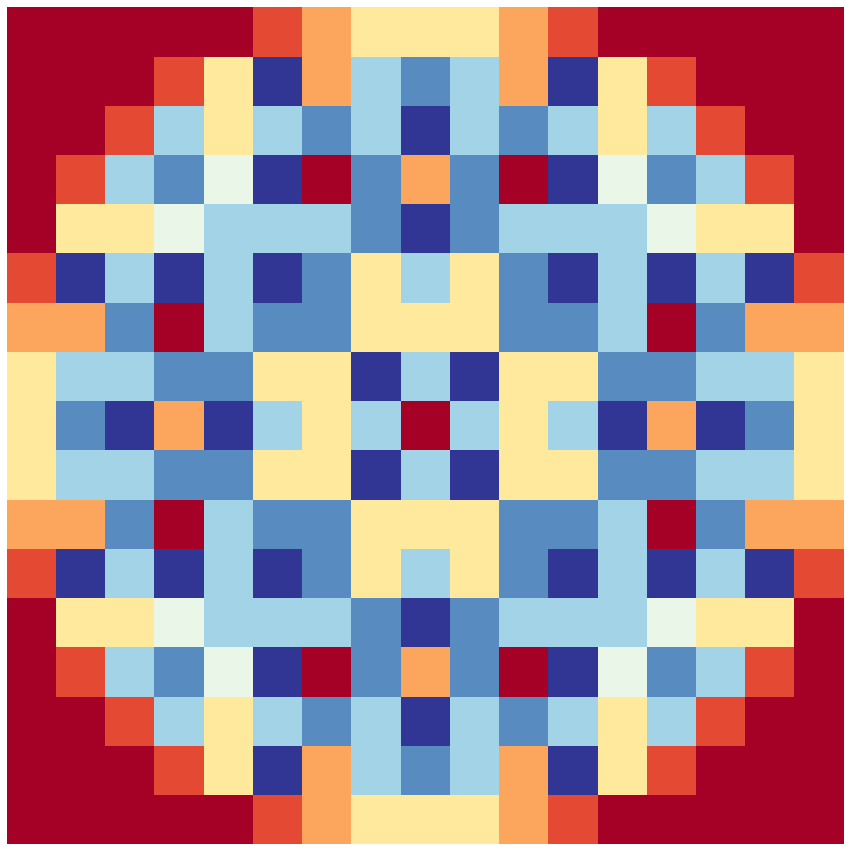

In [474]:
plt.figure(figsize=(15, 15))
sns.heatmap(s.grid, cbar=False, xticklabels=False, yticklabels=False, cmap="RdYlBu")

7